In [187]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [188]:
df1 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet')
df2 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet')
df3 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-03.parquet')

In [222]:
df = pd.concat([df1, df2, df3])
df.shape

(146486, 21)

# Target Variable

In [223]:
def target_feature(df, target_col):
    df[target_col] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df[target_col] = df[target_col].dt.total_seconds() / 60  # in minutes
    return df

df = target_feature(df, "durations")

In [224]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'cbd_congestion_fee', 'durations'],
      dtype='object')

# Feature Selection

In [225]:
numeric_cols = ["trip_distance", "extra", "tolls_amount", "passenger_count", "fare_amount"]
categorical_cols = ["VendorID", "trip_type", "lpep_pickup_datetime"]
target = ["durations"]

fil_df = df[numeric_cols+categorical_cols+target]

# EDA

In [226]:
# 99% of the dara is less than 60 mins
fil_df["durations"].describe(percentiles=[0.95, 0.98, 0.99])

count    146486.000000
mean         20.241456
std          91.205274
min          -7.433333
50%          11.583333
95%          34.966667
98%          53.666667
99%          65.288333
max        1500.766667
Name: durations, dtype: float64

In [227]:
# Having negative duration doesn't make sense maybe error during data collection
fil_df[(fil_df["durations"]>=2) & (fil_df["durations"]<=60)]["durations"].describe()

count    137710.000000
mean         14.091009
std           9.147361
min           2.000000
25%           7.850000
50%          11.883333
75%          17.550000
max          60.000000
Name: durations, dtype: float64

In [228]:
train_data_len = len(fil_df)

fil_df = fil_df[(fil_df["durations"]>=2) & (fil_df["durations"]<=60)]
print(f"Train Data loss post filter: {1 - (len(fil_df)/train_data_len)}")

Train Data loss post filter: 0.059910162063268824


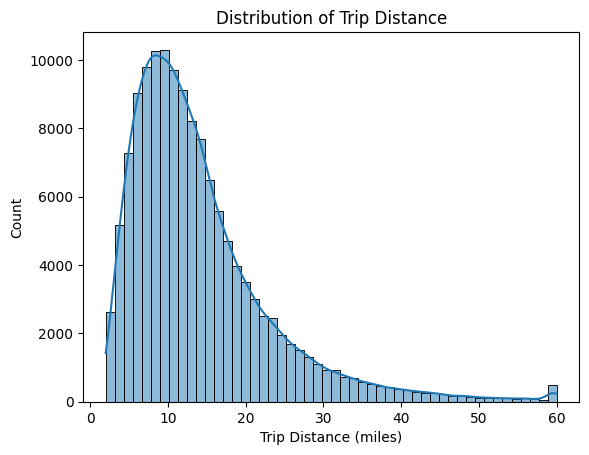

In [229]:
# RECOMMENDED
sns.histplot(data=fil_df, x='durations', bins=50, kde=True)
plt.title("Distribution of Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Count")
plt.show()

In [230]:
if fil_df.index.duplicated().any():
    print("Duplicate index labels found. Resetting index...")
    fil_df = fil_df.reset_index(drop=True)

Duplicate index labels found. Resetting index...


In [231]:
# Missing Values
fil_df.isnull().sum()

trip_distance              0
extra                      0
tolls_amount               0
passenger_count         6247
fare_amount                0
VendorID                   0
trip_type               6260
lpep_pickup_datetime       0
durations                  0
dtype: int64

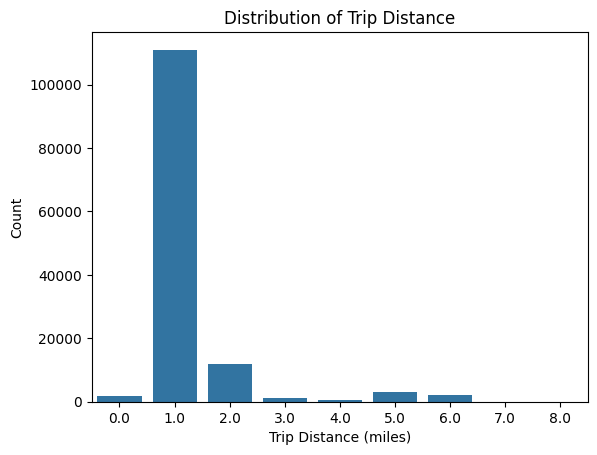

In [232]:
# passenger_count - Numeric
sns.countplot(x='passenger_count', data=fil_df)
plt.title("Distribution of Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Count")
plt.show()

In [233]:
# Most of the time it's just a single person. fill nan with mode
fil_df["passenger_count"].fillna(fil_df["passenger_count"].mode()[0], inplace=True)

/var/folders/n1/931qk00508gd3sf11hlpmdf40000gn/T/ipykernel_9782/113317096.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fil_df["passenger_count"].fillna(fil_df["passenger_count"].mode()[0], inplace=True)


In [234]:
df['trip_type'].value_counts()

trip_type
1.0    132808
2.0      5752
Name: count, dtype: int64

In [235]:
fil_df["trip_type"].fillna(1, inplace=True)

/var/folders/n1/931qk00508gd3sf11hlpmdf40000gn/T/ipykernel_9782/286895257.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fil_df["trip_type"].fillna(1, inplace=True)


In [236]:
for x in categorical_cols:
  print(x, fil_df[x].nunique())

VendorID 3
trip_type 2
lpep_pickup_datetime 135548


In [237]:
# Binary feature
fil_df["trip_type"] = fil_df["trip_type"]-1
fil_df["VendorID"] = fil_df["VendorID"]-1

In [238]:
fil_df["day_of_week"] = fil_df["lpep_pickup_datetime"].dt.dayofweek
# fil_df["day_of_week"] = fil_df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
fil_df["day_of_week"].value_counts()

day_of_week
3    22991
4    21672
2    21433
0    19817
1    19786
5    16991
6    15020
Name: count, dtype: int64

In [239]:
fil_df.head()

,trip_distance,extra,tolls_amount,passenger_count,fare_amount,VendorID,trip_type,lpep_pickup_datetime,durations,day_of_week
0,5.93,1.0,0.00,1.0,24.7,1,0.0,2025-01-01 00:03:01,14.183333,2
1,1.32,1.0,0.00,1.0,8.6,1,0.0,2025-01-01 00:19:59,5.883333,2
2,4.12,1.0,6.94,1.0,21.2,1,0.0,2025-01-01 00:52:24,15.466667,2
3,4.71,1.0,0.00,1.0,33.8,1,0.0,2025-01-01 00:25:05,36.083333,2
4,4.26,1.0,0.00,1.0,31.0,1,0.0,2025-01-01 01:03:45,38.400000,2


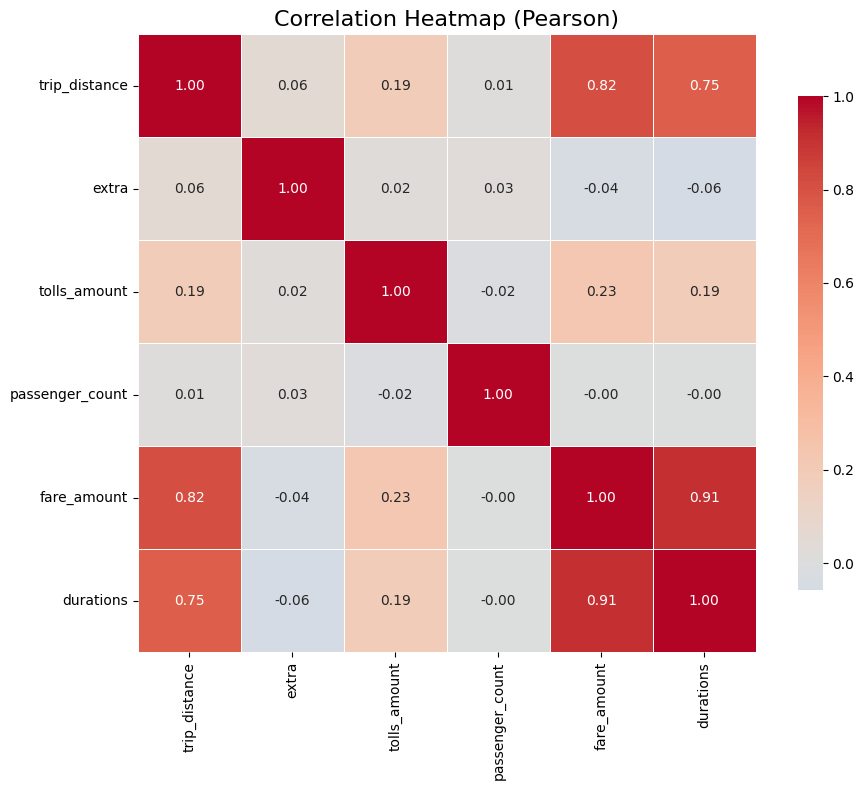

In [240]:
# Compute the Pearson correlation matrix
sub_df = fil_df[numeric_cols+target]
correlation_matrix = sub_df.corr(numeric_only=True, method='spearman')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix,
            annot=True,        # show the correlation numbers
            fmt=".2f",         # format decimal points
            cmap="coolwarm",   # color scheme
            center=0,          # center the colormap at 0
            square=True,       # square cells
            linewidths=0.5,    # lines between cells
            cbar_kws={"shrink": 0.8})  # shrink color bar

# Set plot title
plt.title("Correlation Heatmap (Pearson)", fontsize=16)
plt.tight_layout()
plt.show()

In [241]:
fil_df = fil_df.drop(columns = ["lpep_pickup_datetime"], axis = 0)

In [242]:
fil_df = pd.get_dummies(fil_df, columns=['day_of_week'], prefix='day', dtype=int)

In [243]:
X = fil_df.drop(columns=["durations"])
y = fil_df["durations"]

# Split: 80% training, 20% validation
train_df, test_df = train_test_split(fil_df, test_size=0.2, random_state=12)

In [244]:
train_df.shape

(110168, 15)

In [245]:
train_df.head()

,trip_distance,extra,tolls_amount,passenger_count,fare_amount,VendorID,trip_type,durations,day_0,day_1,day_2,day_3,day_4,day_5,day_6
3536,1.57,1.0,0.0,1.0,12.8,1,0.0,12.316667,0,0,0,0,1,0,0
86761,0.93,0.0,0.0,1.0,9.3,1,0.0,9.566667,0,0,0,0,1,0,0
48652,1.68,0.0,0.0,1.0,10.7,1,0.0,9.266667,1,0,0,0,0,0,0
19909,4.96,2.5,0.0,1.0,26.1,1,0.0,18.633333,0,0,1,0,0,0,0
95548,2.07,0.0,0.0,1.0,10.7,1,0.0,6.400000,0,0,1,0,0,0,0


In [246]:
train_df.to_csv("data/training_data_V2.csv", index = False)
test_df.to_csv("data/test_data_V2.csv", index = False)

In [178]:
train_df.iloc[78, train_df.columns != 'durations']
train_df.iloc[98, train_df.columns == 'durations']

durations    12.4
Name: 17599, dtype: float64

In [181]:
a = test_df.loc[:, test_df.columns!="durations"]
a.shape

(27752, 8)